In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('bmh')
%matplotlib inline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
pd.options.display.max_rows = 14
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sklearn.model_selection as ms
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [13]:
boston = pd.read_csv('bostonhousing.csv')
boston.head()

ID     crim    zn  indus  chas    nox     rm   age     dis  rad  tax  \
0   1  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296   
1   2  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242   
2   3  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242   
3   4  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222   
4   5  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222   

   ptratio   black  lstat  medv  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

In [14]:
boston.shape

(506, 15)

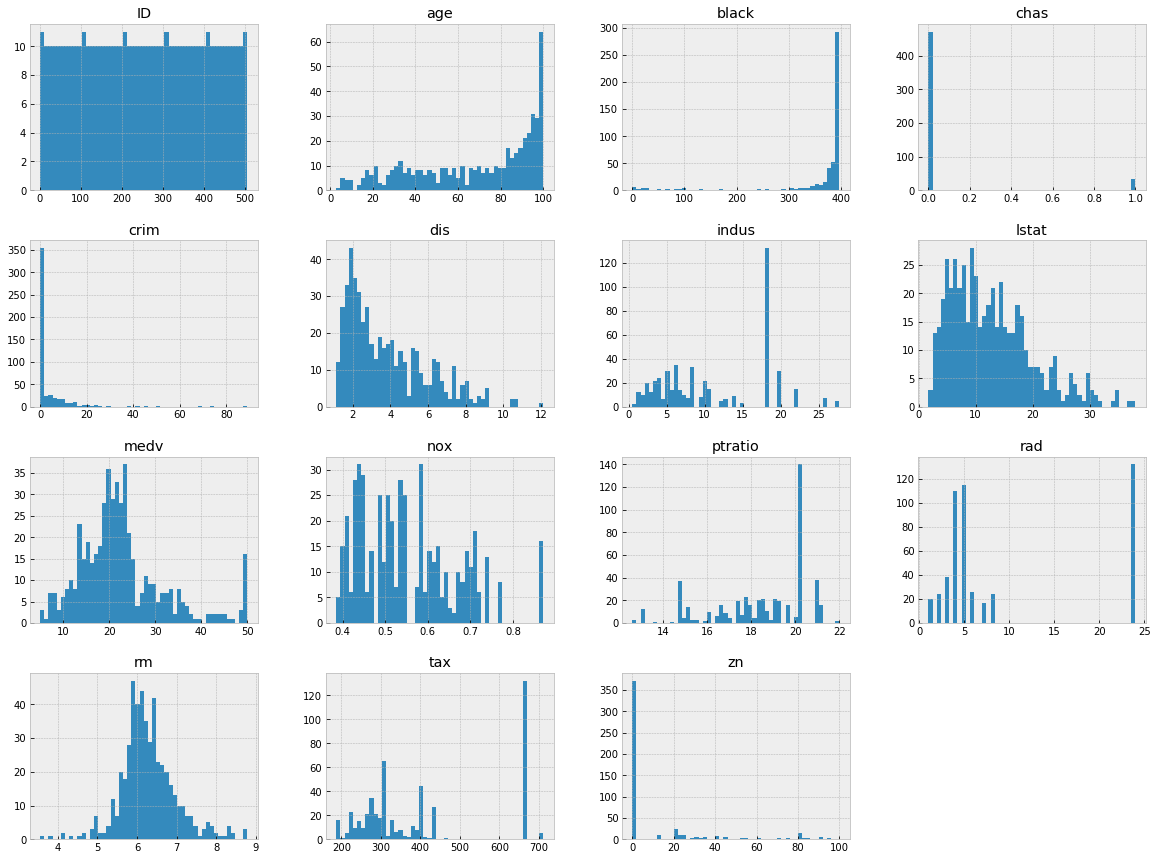

In [15]:
x = boston.hist(bins=50, figsize=(20, 15))
plt.show()
# lstat and rm columns are normally distributed

In [16]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
ID         506 non-null int64
crim       506 non-null float64
zn         506 non-null float64
indus      506 non-null float64
chas       506 non-null int64
nox        506 non-null float64
rm         506 non-null float64
age        506 non-null float64
dis        506 non-null float64
rad        506 non-null int64
tax        506 non-null int64
ptratio    506 non-null float64
black      506 non-null float64
lstat      506 non-null float64
medv       506 non-null float64
dtypes: float64(11), int64(4)
memory usage: 59.4 KB


In [17]:
boston.isnull().any(axis = 0) # no nulls

ID         False
crim       False
zn         False
indus      False
chas       False
nox        False
rm         False
           ...  
dis        False
rad        False
tax        False
ptratio    False
black      False
lstat      False
medv       False
Length: 15, dtype: bool

In [18]:
boston[boston.isnull().any(axis = 1)] # no nulls

Empty DataFrame
Columns: [ID, crim, zn, indus, chas, nox, rm, age, dis, rad, tax, ptratio, black, lstat, medv]
Index: []

In [19]:
boston.describe()
# medv(label) - ranges b/w 5 and 50.
# mean - 22.5, std - 9.19, median - 21.2

ID        crim          zn       indus        chas         nox  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean   253.500000    3.613524   11.363636   11.136779    0.069170    0.554695   
std    146.213884    8.601545   23.322453    6.860353    0.253994    0.115878   
min      1.000000    0.006320    0.000000    0.460000    0.000000    0.385000   
25%    127.250000    0.082045    0.000000    5.190000    0.000000    0.449000   
50%    253.500000    0.256510    0.000000    9.690000    0.000000    0.538000   
75%    379.750000    3.677082   12.500000   18.100000    0.000000    0.624000   
max    506.000000   88.976200  100.000000   27.740000    1.000000    0.871000   

               rm         age         dis         rad         tax     ptratio  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     6.284634   68.574901    3.795043    9.549407  408.237154   18.455534   
std      0.702617   28.148861    2.105710    8.707259  168.537116    2.164946   
min      3.561000    2.900000    1.129600    1.000000  187.000000   12.600000   
25%      5.885500   45.025000    2.100175    4.000000  279.000000   17.400000   
50%      6.208500   77.500000    3.207450    5.000000  330.000000   19.050000   
75%      6.623500   94.075000    5.188425   24.000000  666.000000   20.200000   
max      8.780000  100.000000   12.126500   24.000000  711.000000   22.000000   

            black       lstat        medv  
count  506.000000  506.000000  506.000000  
mean   356.674032   12.653063   22.532806  
std     91.294864    7.141062    9.197104  
min      0.320000    1.730000    5.000000  
25%    375.377500    6.950000   17.025000  
50%    391.440000   11.360000   21.200000  
75%    396.225000   16.955000   25.000000  
max    396.900000   37.970000   50.000000

In [20]:
def splitting(a,b,target):
    split = ms.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for training_indices, test_indices in split.split(a, b):
        stratified_train_set = a.loc[training_indices]
        stratified_test_set = a.loc[test_indices]
        fea_train, lab_train = (stratified_train_set.drop(target, axis = 1), stratified_train_set[target[0]].copy())
        fea_test, lab_test = (stratified_test_set.drop(target, axis = 1), stratified_test_set[target[0]].copy())
    return stratified_train_set, stratified_test_set, fea_train, lab_train, fea_test, lab_test
def catnum(features, col):
    num, cat = (fea_train.drop(col, axis = 1), fea_train[col])
    return num, cat
def meanerror(a,b):
    print('(meansquareerror, r2score) = ' , (np.sqrt(mean_squared_error(a,b)), r2_score(a,b)))
def crossval(reg, data_tr, labels):
    scores = cross_val_score(reg, data_tr, labels, scoring='neg_mean_squared_error', cv=10)
    sq_scores = np.sqrt(-scores)
    print('(cross_val_mean, cross_val_std) = ' , (sq_scores.mean(), sq_scores.std()))

In [21]:
rn_train_set, rn_test_set = ms.train_test_split(boston, test_size = 0.2, random_state=42)  
rn_train_set.shape
rn_test_set.shape

(404, 15)

(102, 15)

In [22]:
boston['lstat'].min(), boston['lstat'].max()

(1.73, 37.969999999999999)

In [23]:
import seaborn as sns
sns.set(style = 'ticks')

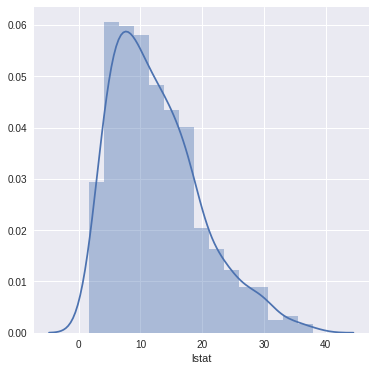

In [24]:
x = sns.set(rc = {'figure.figsize' :(6,6)})
x = sns.distplot(boston['lstat'], kde = True)

In [25]:
lstat1 = boston['lstat'] // 5.5

In [26]:
lstat1.unique()

array([ 0.,  1.,  2.,  3.,  5.,  4.,  6.])

In [27]:
boston.groupby(lstat1).size()

lstat
0.0     78
1.0    168
2.0    127
3.0     77
4.0     33
5.0     17
6.0      6
dtype: int64

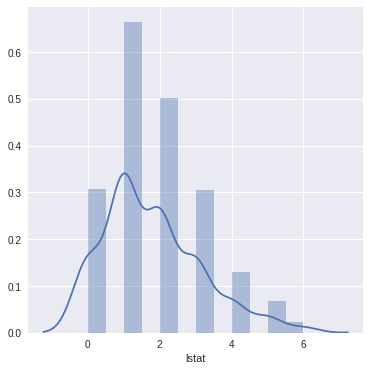

In [28]:
x = sns.set(rc = {'figure.figsize' :(6,6)})
x = sns.distplot(lstat1, kde = True)

In [29]:
lstat1[lstat1 >= 4] = 4

In [30]:
boston.groupby(lstat1).size()

lstat
0.0     78
1.0    168
2.0    127
3.0     77
4.0     56
dtype: int64

In [31]:
stratified_train_set, stratified_test_set, fea_train, lab_train, fea_test, lab_test = splitting(boston, lstat1, ['medv'])

In [32]:
b = boston.groupby(lstat1).size() / len(boston)
b.name = 'boston'
str_test = stratified_test_set.groupby(lstat1).size() / len(stratified_test_set)
str_test.name = 'stratified test'
rn_test = rn_test_set.groupby(lstat1).size() / len(rn_test_set)
rn_test.name = 'random test'

In [33]:
compare = pd.concat([b, str_test, rn_test], axis=1)
compare['stratified test %'] = 100 * (compare['stratified test'] - compare['boston']) / compare['boston']
compare['random test %'] = 100 * (compare['random test'] - compare['boston']) / compare['boston']
compare
# % variation from boston in stratified test is less compared to random test

boston  stratified test  random test  stratified test %  \
lstat                                                              
0.0    0.154150         0.156863     0.127451           1.759678   
1.0    0.332016         0.333333     0.294118           0.396825   
2.0    0.250988         0.254902     0.245098           1.559364   
3.0    0.152174         0.147059     0.215686          -3.361345   
4.0    0.110672         0.107843     0.117647          -2.556022   

       random test %  
lstat                 
0.0       -17.320261  
1.0       -11.414566  
2.0        -2.346765  
3.0        41.736695  
4.0         6.302521

In [34]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.column_names].values

In [35]:
pipeline = Pipeline([('selector', ColumnSelector(list(fea_train))),
                    ('standard_scaler', StandardScaler())
                                 ])

In [36]:
boston_transformed = pipeline.fit_transform(stratified_train_set)
boston_transformed.shape
boston_transformed

(404, 14)

array([[ 0.65714344, -0.41442674,  1.22033405, ...,  0.57878262,
         0.43702583, -0.93904963],
       [ 1.61640458, -0.40447334, -0.50274138, ...,  0.75941467,
         0.41671245,  0.73635294],
       [-0.44114106, -0.41167568,  1.43571848, ..., -1.45332786,
         0.36508727, -1.37038257],
       ..., 
       [ 1.53299057,  0.12494139, -0.50274138, ...,  0.80457268,
         0.42928205,  0.82234214],
       [-1.31003703, -0.41490002,  0.03571969, ...,  0.21751854,
         0.42928205, -0.64502202],
       [-0.51065274, -0.41118333, -0.50274138, ..., -0.27921958,
         0.40582627, -1.09993265]])

In [37]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
x = lin_reg.fit(boston_transformed, lab_train)
h1 = lin_reg.predict(boston_transformed)
h = list(lab_train)
meanerror(h, h1)
crossval(lin_reg, boston_transformed, lab_train)

(meansquareerror, r2score) =  (4.891788570701598, 0.71622265225990667)
(cross_val_mean, cross_val_std) =  (5.0020720984243559, 1.0278452634081969)


In [38]:
# DecisionTreeRegressor
print("DecisionTreeRegressor")
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor()
x = dt_reg.fit(boston_transformed, lab_train)
h2 = dt_reg.predict(boston_transformed)
meanerror(h, h2)
crossval(dt_reg, boston_transformed, lab_train)

DecisionTreeRegressor
(meansquareerror, r2score) =  (0.0, 1.0)
(cross_val_mean, cross_val_std) =  (4.697617171366578, 1.7036935081811106)


In [39]:
# RandomForestRegressor
print("RandomForestRegressor")
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(random_state = 42)
x = rf_reg.fit(boston_transformed, lab_train)
h3 = rf_reg.predict(boston_transformed)
meanerror(h, h3)
crossval(rf_reg, boston_transformed, lab_train)

RandomForestRegressor
(meansquareerror, r2score) =  (1.3949655767781652, 0.97692353131887943)
(cross_val_mean, cross_val_std) =  (3.4057844634291086, 1.2418132099559076)


In [60]:
# Model                                 meansquare error                           crossvalidation
#-----------------------------------------------------------------------------------------------------------------
# linear regression                    4.891788570701598                           5.0020720984243559
# Decision tree regression             0.0                                         4.697617171366578
# random forest regression             1.3949655767781652                          3.4057844634291086

(<matplotlib.text.Text at 0x7f784dfd95c0>,
 <matplotlib.text.Text at 0x7f784dfc2780>)

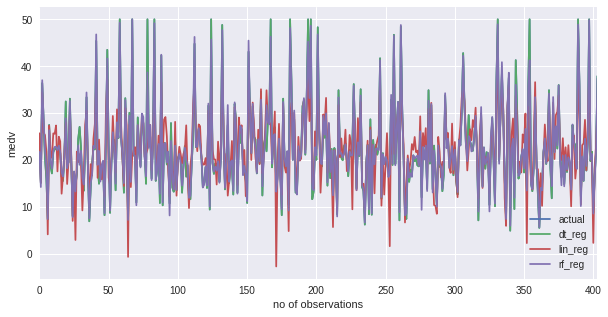

In [87]:
h= np.asarray(h)
df = pd.DataFrame({'actual': h,  'dt_reg' : h2, 'lin_reg': h1, 'rf_reg': h3})
sns.set_style("darkgrid")
x = df.plot(kind='line', figsize=(10,5))
plt.xlabel('no of observations'), plt.ylabel('medv')
plt.show()

# Gridsearch

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [43]:
param_grid = [
        {'n_estimators': [40, 50, 60, 70, 80], 'max_features': [4, 5,6,7,8]},
    ]
rf_reg2 = RandomForestRegressor(random_state = 42)
grid_search = GridSearchCV(rf_reg2, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs = 4)
x = grid_search.fit(boston_transformed, lab_train)
grid_search.best_params_

{'max_features': 5, 'n_estimators': 70}

In [44]:
param_grid = [
        {'n_estimators': [40, 60, 70, 75, 80], 'max_features': [4, 5,6,7,8]},
    ]
rf_reg2 = RandomForestRegressor(random_state = 42)
grid_search = GridSearchCV(rf_reg2, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs = 4)
x = grid_search.fit(boston_transformed, lab_train)
grid_search.best_params_

{'max_features': 5, 'n_estimators': 70}

In [45]:
# 'max_features': 5, 'n_estimators': 70

In [46]:
final_model = grid_search.best_estimator_
boston_transformed = pipeline.transform(fea_train)
predictions = final_model.predict(boston_transformed)
meanerror(lab_train,predictions)
crossval(rf_reg2, boston_transformed, lab_train)

(meansquareerror, r2score) =  (1.2593699011765727, 0.98119172403698907)
(cross_val_mean, cross_val_std) =  (3.4057844634291086, 1.2418132099559076)


In [47]:
final_model = grid_search.best_estimator_
test_transformed = pipeline.transform(fea_test)
predictions = final_model.predict(test_transformed)
meanerror(lab_test,predictions)

(meansquareerror, r2score) =  (2.9846993470158489, 0.89458928562170414)


In [48]:
# meansquare error
#Before tuning
#(meansquareerror, r2score) =  (1.3949655767781652, 0.97692353131887943)
# after tuning
#training error - 1.2593699011765727, test error - 2.9846993470158489

# Randomizedsearch

In [49]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid = {"max_features": randint(1, 11), 'n_estimators': randint(10,100,10) }
rf_reg3 = RandomForestRegressor(random_state = 42)
random_search = RandomizedSearchCV(rf_reg3, param_grid)
x = random_search.fit(boston_transformed, lab_train)

final_model = random_search.best_estimator_
boston_transformed = pipeline.transform(fea_train)
predictions = final_model.predict(boston_transformed)
meanerror(lab_train,predictions)
crossval(rf_reg3, boston_transformed, lab_train)

(meansquareerror, r2score) =  (1.1740899769966748, 0.98365273396144448)
(cross_val_mean, cross_val_std) =  (3.4057844634291086, 1.2418132099559076)


In [50]:
final_model = random_search.best_estimator_
test_transformed = pipeline.transform(fea_test)
predictions = final_model.predict(test_transformed)
meanerror(lab_test,predictions), random_search.best_params_

(meansquareerror, r2score) =  (2.8928490032590224, 0.9009772218507196)


(None, {'max_features': 7, 'n_estimators': 89})

In [61]:
# meansquare error
#training error - 1.1740899769966748, test error - 2.8928490032590224

# features

In [52]:
# feature importances
imps = grid_search.best_estimator_.feature_importances_
imps

array([ 0.07429088,  0.05165913,  0.00504268,  0.058339  ,  0.0049242 ,
        0.04773552,  0.24976616,  0.0256102 ,  0.05522855,  0.00863901,
        0.0155442 ,  0.05862479,  0.01345429,  0.33114138])

In [53]:
# printing column names against values
for fea, imp in zip(fea_train, imps):
    print(fea, imp )

ID 0.0742908831014
crim 0.0516591270114
zn 0.00504268277298
indus 0.0583390021629
chas 0.00492420248441
nox 0.0477355208988
rm 0.249766157648
age 0.025610200388
dis 0.0552285533359
rad 0.00863901436212
tax 0.0155441979152
ptratio 0.0586247905729
black 0.0134542881182
lstat 0.331141379228


In [54]:
def feature(a, b):
    fea = []
    for i in range(b):
        fea.append(a[i][1])
    return fea

In [55]:
# sorting features based on vfeatureimportances
s2 = sorted(zip(imps, range(len(fea_train))), reverse = True)
s2

[(0.33114137922803744, 13),
 (0.24976615764783533, 6),
 (0.074290883101362171, 0),
 (0.058624790572914441, 11),
 (0.058339002162887406, 3),
 (0.055228553335891932, 8),
 (0.051659127011387869, 1),
 (0.047735520898848652, 5),
 (0.025610200387965472, 7),
 (0.015544197915213156, 10),
 (0.013454288118151121, 12),
 (0.0086390143621213299, 9),
 (0.005042682772977679, 2),
 (0.0049242024844059927, 4)]

In [56]:
feature(s2, 11) # dropped last 3 features

[13, 6, 0, 11, 3, 8, 1, 5, 7, 10, 12]

In [57]:
imp_features = feature(s2, 11)

In [58]:
# RandomForestRegressor
print("RandomForestRegressor")
from sklearn.ensemble import RandomForestRegressor
rf_reg4 = RandomForestRegressor()
x = rf_reg4.fit(boston_transformed[:,imp_features], lab_train)
h3 = rf_reg4.predict(boston_transformed[:,imp_features])
meanerror(h, h3)
crossval(rf_reg4, boston_transformed[:,imp_features], lab_train)

RandomForestRegressor
(meansquareerror, r2score) =  (1.6129348749689458, 0.96914851777680011)
(cross_val_mean, cross_val_std) =  (3.3059713482674633, 1.0225341692879708)


In [64]:
test_transformed = pipeline.transform(fea_test)
predictions = rf_reg4.predict(test_transformed[:,imp_features])
meanerror(lab_test,predictions)

(meansquareerror, r2score) =  (3.2095235123722938, 0.8781109481872853)


# Adding attribute adder

In [65]:
# rpb --- ratio of residentialzone to non retail business zone
# bpb --- ratio of no of blacks to non retail business  zone 
zn_col, indus_col, nox_col, age_col, black_col = 2, 3, 5, 7, 12
class AttributeAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rpb = X[:, zn_col] / X[:, indus_col]
        bpb = X[:, black_col] / X[:, indus_col]
        return np.c_[X, rpb, bpb]

In [66]:
pipeline1 = Pipeline([('selector', ColumnSelector(list(fea_train))),
                      ('attribute_adder', AttributeAdder()),
                    ('standard_scaler', StandardScaler())
                                 ])

In [67]:
boston_transformed1 = pipeline1.fit_transform(stratified_train_set)
boston_transformed1.shape
boston_transformed1

(404, 16)

array([[ 0.65714344, -0.41442674,  1.22033405, ..., -0.93904963,
         1.89772695,  3.57459183],
       [ 1.61640458, -0.40447334, -0.50274138, ...,  0.73635294,
        -0.33079465, -0.65570098],
       [-0.44114106, -0.41167568,  1.43571848, ..., -1.37038257,
         0.58021073,  0.72900267],
       ..., 
       [ 1.53299057,  0.12494139, -0.50274138, ...,  0.82234214,
        -0.33079465, -0.54902988],
       [-1.31003703, -0.41490002,  0.03571969, ..., -0.64502202,
        -0.18738176,  0.05610779],
       [-0.51065274, -0.41118333, -0.50274138, ..., -1.09993265,
        -0.33079465,  1.38035798]])

In [68]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
x = lin_reg.fit(boston_transformed1, lab_train)
h1 = lin_reg.predict(boston_transformed1)
h = list(lab_train)
meanerror(h, h1)
crossval(lin_reg, boston_transformed1, lab_train)

(meansquareerror, r2score) =  (4.8047238996128323, 0.7262341693566553)
(cross_val_mean, cross_val_std) =  (4.9660719249905121, 0.99730927933640701)


In [69]:
# DecisionTreeRegressor
print("DecisionTreeRegressor")
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor()
x = dt_reg.fit(boston_transformed1, lab_train)
h2 = dt_reg.predict(boston_transformed1)
meanerror(h, h2)
crossval(dt_reg, boston_transformed1, lab_train)

DecisionTreeRegressor
(meansquareerror, r2score) =  (0.0, 1.0)
(cross_val_mean, cross_val_std) =  (4.5456885508902634, 1.7345211930203914)


In [70]:
# RandomForestRegressor
print("RandomForestRegressor")
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(random_state=42)
x = rf_reg.fit(boston_transformed1, lab_train)
h3 = rf_reg.predict(boston_transformed1)
meanerror(h, h3)
crossval(rf_reg, boston_transformed1, lab_train)

RandomForestRegressor
(meansquareerror, r2score) =  (1.4876360075936277, 0.97375565532863195)
(cross_val_mean, cross_val_std) =  (3.4300059358247532, 1.2474914192821411)


In [71]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid = {"max_features": randint(1, 11), 'n_estimators': randint(10,100,10) }
rf_reg5 = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(rf_reg5, param_grid)
x = random_search.fit(boston_transformed1, lab_train)

final_model1 = random_search.best_estimator_
boston_transformed = pipeline1.transform(fea_train)
predictions = final_model1.predict(boston_transformed1)
meanerror(lab_train,predictions)
crossval(rf_reg5, boston_transformed1, lab_train)

(meansquareerror, r2score) =  (1.2702232062561265, 0.98086614603812183)
(cross_val_mean, cross_val_std) =  (3.4300059358247532, 1.2474914192821411)


In [72]:
final_model1 = random_search.best_estimator_
test_transformed = pipeline1.transform(fea_test)
predictions = final_model1.predict(test_transformed)
meanerror(lab_test,predictions), random_search.best_params_

(meansquareerror, r2score) =  (2.7816389733869826, 0.90844436045966726)


(None, {'max_features': 9, 'n_estimators': 47})

In [84]:
# Randomisedsearch cv
# training error - 1.2702232062561265, test error - 2.7816389733869826

# corrmatrix

In [74]:
corr_matrix = boston.corr()
corr_matrix = np.abs(corr_matrix)
corr_matrix = corr_matrix.medv.sort_values(ascending=False)
corr_matrix

medv       1.000000
lstat      0.737663
rm         0.695360
ptratio    0.507787
indus      0.483725
tax        0.468536
nox        0.427321
             ...   
rad        0.381626
age        0.376955
zn         0.360445
black      0.333461
dis        0.249929
ID         0.226604
chas       0.175260
Name: medv, Length: 15, dtype: float64

In [75]:
corr_columns = corr_matrix.index[1:7]
boston[corr_columns].head()

lstat     rm  ptratio  indus  tax    nox
0   4.98  6.575     15.3   2.31  296  0.538
1   9.14  6.421     17.8   7.07  242  0.469
2   4.03  7.185     17.8   7.07  242  0.469
3   2.94  6.998     18.7   2.18  222  0.458
4   5.33  7.147     18.7   2.18  222  0.458

In [76]:
pipeline2 = Pipeline([('selector', ColumnSelector(list(corr_columns))),
                    ('standard_scaler', StandardScaler())
                                 ])

In [77]:
boston_transformed2 = pipeline2.fit_transform(stratified_train_set)
boston_transformed2.shape
boston_transformed2

(404, 6)

array([[-0.93904963,  0.30155041,  0.57878262, -1.46780871, -0.4753933 ,
        -1.08688651],
       [ 0.73635294, -1.16179544,  0.75941467,  2.44509498,  1.79199794,
         0.46161662],
       [-1.37038257,  1.27334766, -1.45332786, -1.14431837, -0.09548466,
        -1.01806415],
       ..., 
       [ 0.82234214,  0.29307544,  0.80457268,  1.02114664,  1.52063463,
         0.5046306 ],
       [-0.64502202, -0.56289714,  0.21751854, -0.75583454, -0.41509034,
        -1.25894241],
       [-1.09993265,  1.24086025, -0.27921958, -1.28907661, -1.33169531,
        -0.5793216 ]])

In [78]:
from sklearn.linear_model import LinearRegression
l_g = LinearRegression()
x = l_g.fit(boston_transformed2, lab_train)
h1 = l_g.predict(boston_transformed2)
h = list(lab_train)
meanerror(h, h1)
crossval(l_g, boston_transformed2, lab_train)

(meansquareerror, r2score) =  (5.4020591875616395, 0.65393231659954321)
(cross_val_mean, cross_val_std) =  (5.3844331408235071, 1.2869441236224599)


In [79]:
# DecisionTreeRegressor
print("DecisionTreeRegressor")
from sklearn.tree import DecisionTreeRegressor
d_g = DecisionTreeRegressor()
x = d_g.fit(boston_transformed2, lab_train)
h2 = d_g.predict(boston_transformed2)
meanerror(h, h2)
crossval(d_g, boston_transformed2, lab_train)

DecisionTreeRegressor
(meansquareerror, r2score) =  (0.0, 1.0)
(cross_val_mean, cross_val_std) =  (4.8776068262047962, 2.0612844835517268)


In [80]:
# RandomForestRegressor
print("RandomForestRegressor")
from sklearn.ensemble import RandomForestRegressor
r_g = RandomForestRegressor(random_state = 42)
x = r_g.fit(boston_transformed2, lab_train)
h3 = r_g.predict(boston_transformed2)
meanerror(h, h3)
crossval(r_g, boston_transformed2, lab_train)

RandomForestRegressor
(meansquareerror, r2score) =  (1.6113710262253125, 0.96920831394474594)
(cross_val_mean, cross_val_std) =  (3.9014811658901438, 1.4382130380066407)


In [81]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_grid = {"max_features": randint(1, 6), 'n_estimators': randint(10,100,10) }
r_r = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(r_r, param_grid)
x = random_search.fit(boston_transformed2, lab_train)

final_model = random_search.best_estimator_
boston_transformed2 = pipeline2.transform(fea_train)
predictions = final_model.predict(boston_transformed2)
meanerror(lab_train,predictions)
crossval(r_r, boston_transformed2, lab_train)

(meansquareerror, r2score) =  (1.2942924602782822, 0.98013414725980363)
(cross_val_mean, cross_val_std) =  (3.9014811658901438, 1.4382130380066407)


In [82]:
final_model = random_search.best_estimator_
test_transformed = pipeline2.transform(fea_test)
predictions = final_model.predict(test_transformed)
meanerror(lab_test,predictions), random_search.best_params_

(meansquareerror, r2score) =  (2.9245203937165054, 0.89879711716753186)


(None, {'max_features': 2, 'n_estimators': 101})

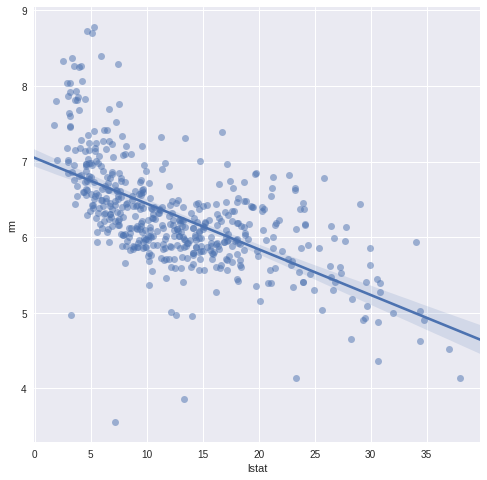

In [83]:
x = sns.set(rc = {'figure.figsize' :(8,8)})
x = sns.regplot(x = 'lstat', y = 'rm', data = boston, scatter_kws={'alpha' : 0.5})

In [85]:
#                                         training error                         test error
#--------------------------------------------------------------------------------------------------------------
#normal                                  1.2593699011765727                   2.9846993470158489
#dropping features                       1.6129348749689458                   3.2095235123722938
#attribute adder                         1.2702232062561265                   2.7816389733869826
#considering only corr_columns           1.2942924602782822                   2.9245203937165054